# Homework (40 pts) - PCA and Classification

---
## Load EEG recordings...

### `eeg_uV[channel, time point, trial]`

In [3]:
from scipy.io import loadmat

data = loadmat('eeg.mat')

# grab relevant data, EEG units are microvolts (uV)
# each channel is an electrode, each trial is a separate EEG recording from that electrode
eeg_uV = data["EEG"][0,0]["data"]  # [channel, time, trial]
time_ms = data["EEG"][0,0]["times"][0]

eeg_uV.shape, time_ms.shape

((64, 640, 99), (640,))

---
1. (5 pts) From the EEG data above, generate the average EEG across trials for each channel for times between 0 and 500 ms. Plot the result for channel 20.

In [5]:
import numpy as np

timeIndices = np.where((time_ms >= 0) & (time_ms <= 500))[0]

eeg = eeg_uV[:,timeIndices,:].mean(axis=2)
time = time_ms[timeIndices]

eeg.shape, time.shape

((64, 129), (129,))

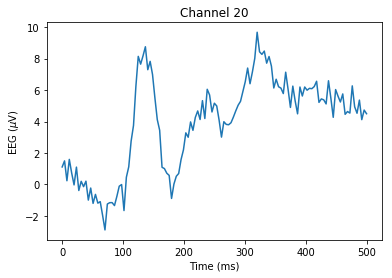

In [10]:
import matplotlib.pyplot as plt

plt.plot(time, eeg[20,:])
plt.xlabel('Time (ms)')
plt.ylabel('EEG ($\mu$V)')
plt.title('Channel 20');

---
2. (5 pts) Apply PCA to the averaged EEGs from #1 above. Use as many principal components (PCs) as needed to explain 90% of the variance in the EEG waveforms. Report the number of PCs used and plot each PC as if it were an EEG waveform itself.

In [17]:
from sklearn.decomposition import PCA

pca = PCA(0.9)

pc = pca.fit_transform(eeg)

n = pca.n_components_

print(f'The number of PCs needed to explain 90% of the variance in the EEGs is {n}.')

The number of PCs needed to explain 90% of the variance in the EEGs is 3.


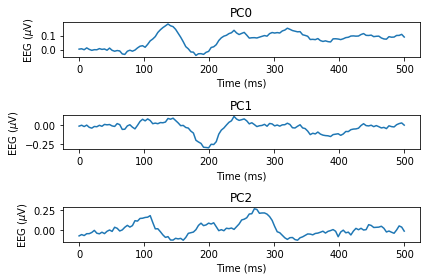

In [18]:
for i in range(n):
    plt.subplot(n, 1, i+1)
    plt.plot(time, pca.components_[i,:])
    plt.xlabel('Time (ms)')
    plt.ylabel('EEG ($\mu$V)')
    plt.title(f'PC{i}')
plt.tight_layout();

---
3. (5 pts) Replot the average EEG for channel 20 as in #1 above, and additionally overlay the plot of its projection onto the principal components from #2 above. Use a legend to label the plots as 'original' and 'projected'. Does it look like we lost a lot of information by describing each waveform using only a small number of PCs as opposed to 129 time points?

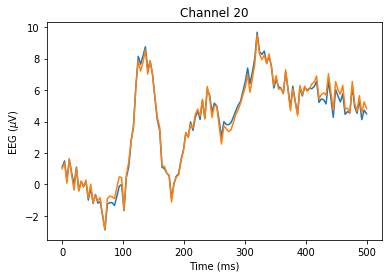

In [19]:
projected = pca.inverse_transform(pc);

plt.plot(time, eeg[20,:], label='original')
plt.plot(time, projected[20,:], label='projected')
plt.xlabel('Time (ms)')
plt.ylabel('EEG ($\mu$V)')
plt.title('Channel 20');

Very little information was lost using only three principal components as compared to 129 time points. Furthermore, it looks like the difference is within the noise in the original waveform.

---
4. (5 pts) How much of each of the PCs were mixed together to generate the projection for channel 20 as shown in #3 above? Plot the relative amounts of each PC as a bar graph. Use only a single tick mark on the x-axis for each PC.

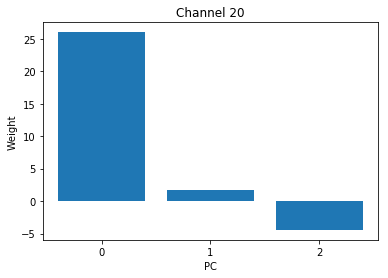

In [21]:
plt.bar(range(n), pc[20,:])
plt.xticks(range(n))
plt.xlabel('PC')
plt.ylabel('Weight')
plt.title('Channel 20');

---
5. (5 pts) Use k-means to group the EEG waveforms into three clusters in the PCA reduced dimensions. Plot the EEG waveforms as points in the PCA reduced dimensions (axes are the PCs) colored according to their cluster. For visualization, if you have more than three PCs, use only the first three PCs in the plot.

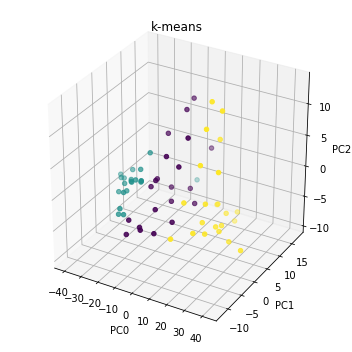

In [58]:
from sklearn.cluster import KMeans
from mpl_toolkits import mplot3d

kmeans = KMeans(3)
clusters = kmeans.fit_predict(pc)

plt.figure(figsize=(5, 5))
ax = plt.subplot(111, projection='3d')
ax.scatter(pc[:,0], pc[:,1], pc[:,2], c=clusters)
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
plt.title('k-means')
plt.tight_layout();

---
6. (5 pts) For each of the three clusters from #5 above, plot all of the averaged EEGs belonging to that cluster overlaid on each other. Additionally, overlay on each cluster plot the cluster average plotted as a black line of width 2. How well do you think the clustering did?

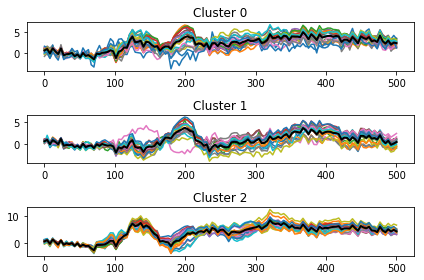

In [59]:
for i in range(3):
    clusterChannels = np.where(clusters == i)[0]
    clusterAvg = eeg[clusterChannels,:].mean(axis=0)
    plt.subplot(3, 1, i+1)
    plt.plot(time.T, eeg[clusterChannels,:].T)
    plt.plot(time, clusterAvg, 'k', lw=2)
    plt.title(f'Cluster {i}')
plt.tight_layout();

Overall, the clustering did a preetty good job segregating the waveforms into three distinct types. However, there is at least one obvious missclassification where one of the EEGs clearly should belong to a different cluster. Additionally, there is some ambiguity for a few traces as to whether they should belong to either of two clusters.

---
7. (5 pts) Repeat #5-#6, but this time use a Gaussian mixture model to cluster the EEGs. Do you prefer the clusters generated by k-means of GMM?

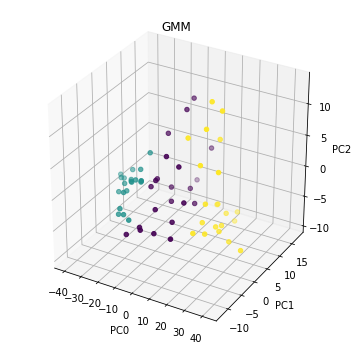

In [60]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(3)
clusters = gmm.fit_predict(pc)

plt.figure(figsize=(5, 5))
ax = plt.subplot(111, projection='3d')
ax.scatter(pc[:,0], pc[:,1], pc[:,2], c=clusters)
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
plt.title('GMM')
plt.tight_layout();

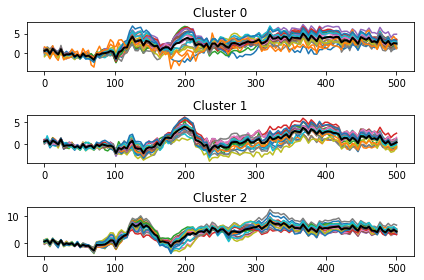

In [61]:
for i in range(3):
    clusterChannels = np.where(clusters == i)[0]
    clusterAvg = eeg[clusterChannels,:].mean(axis=0)
    plt.subplot(3, 1, i+1)
    plt.plot(time.T, eeg[clusterChannels,:].T)
    plt.plot(time, clusterAvg, 'k', lw=2)
    plt.title(f'Cluster {i}')
plt.tight_layout();

GMM clusters do not have the one clear outlier that arose in the k-means clusters, so GMM would be my preference. However, other than this single outlier, the resulting clustering appears very similar, so this preference would be be small in my opinion. It may also be worth trying a different number of clusters for both k-means and GMM.

---
8. (5 pts) Repeat #5-#6, but this time use heirarchical agglomerative clustering with euclidian affinity and ward linkage.

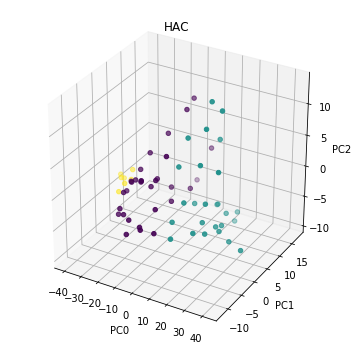

In [75]:
from sklearn.cluster import AgglomerativeClustering

hac = AgglomerativeClustering(3, affinity='euclidean', linkage='ward')
clusters = hac.fit_predict(pc)

plt.figure(figsize=(5, 5))
ax = plt.subplot(111, projection='3d')
ax.scatter(pc[:,0], pc[:,1], pc[:,2], c=clusters)
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
plt.title('HAC')
plt.tight_layout();

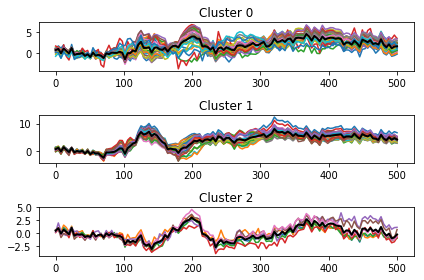

In [76]:
for i in range(3):
    clusterChannels = np.where(clusters == i)[0]
    clusterAvg = eeg[clusterChannels,:].mean(axis=0)
    plt.subplot(3, 1, i+1)
    plt.plot(time.T, eeg[clusterChannels,:].T)
    plt.plot(time, clusterAvg, 'k', lw=2)
    plt.title(f'Cluster {i}')
plt.tight_layout();